In [1]:
# Name: Ege Ersü
# Student ID: 59741

# Linear Regression on Housing Data
In the first lab assignment, you played with Boston Housing Dataset. In this lab assignment, you are going to implement a linear regression model trained on Boston Housing Data by using Knet for the first time. We will take advantage of iterators, callable objects and automatic differentation mechanism.

In [2]:
# Necessary imports
using Pkg; for p in ("Knet","AutoGrad","Plots","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet
using Statistics
using Random
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take, repeat

using Plots; default(fmt=:png,ls=:auto)

┌ Info: Recompiling stale cache file /mnt/juliabox/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190
┌ Warning: Package Plots does not have REPL in its dependencies:
│ - If you have Plots checked out for development and have
│   added REPL as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Plots
└ Loading REPL into Plots from project dependency, future warnings for Plots are suppressed.


## Data Reading
You do not need to worry about data reading and preprocessing: We are going to take advantage of housing data reader which is also a part of Knet. We include some source file and then use ```housing``` function. ```housing``` function takes one input argument: the percentage of the test set to split dataset into two parts. Just take a look at the cell below. In this lab session, we are going to use 20% of the data as test split.

In [310]:
include(joinpath(Knet.dir(), "data", "housing.jl"))
Knet.seed!(1)
xtrn, ytrn, xtst, ytst = housing(0.20; url="https://raw.githubusercontent.com/ilkerkesen/ufldl-tutorial/master/ex1/housing.data")

([-0.410443 -0.113706 … -0.328758 -0.415011; -0.48724 -0.48724 … 0.370303 2.94293; … ; 0.37599 -0.068175 … 0.300082 0.440616; 0.185818 -0.00182931 … 0.299246 -0.337914], [26.4 16.1 … 30.7 19.4], [-0.40099 -0.416566 … -0.403706 -0.405478; 0.456057 -0.48724 … -0.48724 1.44223; … ; 0.197557 0.417723 … 0.440616 0.286609; -0.438739 -0.293103 … 0.446283 -1.13331], [24.5 18.5 … 20.3 29.8])

In [311]:
size(xtrn), size(ytrn), size(xtst), size(ytst)

((13, 405), (1, 405), (13, 101), (1, 101))

## Minibatching via Iterators
In this part, you are going implement a minibatching procedure (or let's call it pipeline). Remember, you need to implement your own ```minibatch``` function, it's forbidden to use Knet's ```minibatch``` procedure. Also, your minibatching scheme must use iterators. Just take a look at [this blog post](https://julialang.org/blog/2018/07/iterators-in-julia-0.7). To implement your minibatching pipeline, we provide you ```HousingData``` struct definition. Different from the original implementation, you are not going to discard the last remaining smaller minibatch, you will use all the instances. Also, remember that, ```HousingData``` structure is not mutable which means you are not able to change the values inside struct.

In [312]:
# DO NOT TOUCH THIS CELL
struct HousingDataMinibatch
    x
    y
    batchsize
    shuffle # shuffle data in each epoch or not
    ninstances # number of instances
end

In [326]:
# This function constructs a HousingData object
function HousingDataMinibatch(x, y; batchsize=100, dtype=Array{Float64}, shuffle=false)
    # start your answer
    hd = HousingDataMinibatch(x, y, batchsize, shuffle, size(x)[2])
end

HousingDataMinibatch

In [325]:
# Returns how many batches the dataset has (hint: you can use divrem function)
function length(d::HousingDataMinibatch)
    size(d.x)[1]
end

length (generic function with 151 methods)

In [324]:
# Returns a random minibatch (hint: you can use randperm function)
function rand(d::HousingDataMinibatch)
    # start your answer
    #Shuffles random from 1 to ninstances
    indx = randperm(d.ninstances)[1:d.batchsize]
    x = d.x[:,indx]
    y = d.y[:,indx]
    #x = d.x[:, 1:indx]
    #y = d.y[:, 1:indx]
    # end your answer
    return (x, y)
end

rand (generic function with 70 methods)

In [316]:
# This is how you implement your own iterator!
#function iterate(d::HousingDataMinibatch, state=ifelse(d.shuffle, randperm(d.ninstances), 1:d.ninstances))

function iterate(d::HousingDataMinibatch, state=ifelse(d.shuffle, randperm(d.ninstances), 1:d.batchsize))
    
    if state == "done"
        return nothing
    end
    
    if d.shuffle == false

        if state[1] + d.batchsize > d.ninstances
            x_batch = d.x[:,(state[1]:d.ninstances)]
            y_batch = d.y[:,(state[1]:d.ninstances)]
            return (x_batch, y_batch), "done"
            return nothing
        end

        x_batch = d.x[:, state]
        y_batch = d.y[:, state]

        state = (state[1]+d.batchsize) : (state[1]+ (2*d.batchsize)-1)

        return (x_batch, y_batch), state
    end
    
    
    if d.shuffle == true
        
        if size(state)[1] < d.batchsize
            x_batch = d.x[:, state[1:size(state)[1]]]
            y_batch = d.y[:, state[1:size(state)[1]]]
            return (x_batch, y_batch), "done"
        end

        x_batch = d.x[:, state[1:d.batchsize]]
        y_batch = d.y[:, state[1:d.batchsize]]
                
        state = state[d.batchsize+1:size(state)[1]]
                return (x_batch, y_batch), state
        
    end
end

iterate (generic function with 277 methods)

In [317]:
dtrn = HousingDataMinibatch(xtrn, ytrn; shuffle=true)
dtst = HousingDataMinibatch(xtst, ytst)

HousingDataMinibatch([-0.40099 -0.416566 … -0.403706 -0.405478; 0.456057 -0.48724 … -0.48724 1.44223; … ; 0.197557 0.417723 … 0.440616 0.286609; -0.438739 -0.293103 … 0.446283 -1.13331], [24.5 18.5 … 20.3 29.8], 100, false, 101)

In [318]:
# just testing
for (x, y) in dtrn
    println(size(x), ", ", size(y))
end

# needs to have the following output
# (13, 100), (1, 100)
# (13, 100), (1, 100)
# (13, 100), (1, 100)
# (13, 100), (1, 100)
# (13, 5), (1, 5)

(13, 100), (1, 100)
(13, 100), (1, 100)
(13, 100), (1, 100)
(13, 100), (1, 100)
(13, 5), (1, 5)


## Model Implementation via Callable Objects
Next, we are going to implement our model via callable objects. In Julia, we can call objects. Just give a glimpse at the following code snippet:

In [319]:
struct Hello
    planet
    Hello(planet="World") = new(planet)
end

(obj::Hello)() = println("Hello, $(obj.planet)!")

hello_world = Hello()
hello_world()

hello_jupiter = Hello("Jupiter")
hello_jupiter()

Hello, World!
Hello, Jupiter!


For this assingment, you just need to define a linear layer and that's all! Write your solutions to the below cell. Hint: You need to use ```Param``` method of AutoGrad. Just type ```@doc Param``` to see the documentation.

In [320]:
struct Linear1; w; b; end

Linear1(xsize::Int, ysize::Int, atype=Array{Float64}, scale=0.1)=
    Linear1(Param(scale*randn(1,13)), Param(zeros(1)))

(l::Linear1)(x) = (l.w * x) .+ l.b

model = Linear1(1,13)

Linear1(P(Array{Float64,2}(1,13)), P(Array{Float64,1}(1)))

## Define Loss Function
In this part, we'll define our loss function. We are going to use minimum squared error loss function,

![MSE](http://web.itu.edu.tr/keseni/mse.png)

We're going to define three diffent functions for this purpose,

1. A function takes predictions and gold values as input.
2. A callable object procedure that takes input/output pair as input
3. A callable object procedure that takes our dataset object as input

See function prototypes below and the documentation of ```train!``` function.

In [321]:
# 1 - takes predictions and gold values as input.
function mse(ypred, ygold)
    N = size(ypred)[2]
    sub = (x->x*x).(ygold - ypred)
    loss = sum(sub)/(2*N)
    loss
end


# 2 - callable object procedure that takes input/output pair as input
function (m::Linear1)(x, y)
    mse(m(x), y)
end


# 3 - callable object procedure that takes our dataset object as input
function (m::Linear1)(data::HousingDataMinibatch)
    mean(m(x,y) for (x,y) in data)
end

model = Linear1(1,13)

@show mse(model(xtrn), ytrn)
@show model(xtrn,ytrn)
@show model(dtrn)

mse(model(xtrn), ytrn) = 295.7437337692845
model(xtrn, ytrn) = 295.7437337692845
model(dtrn) = 275.556436549272


275.556436549272

## Training with Modular Interface and Iterators
Now, let's implement a ```mytrain!``` procedure to train our network! It takes model, train data, test data, report period (in iterations) and number of maximum iterations. It trains our model until a certain maximum iterations number, records loss values of train and test data splits after each report period. It should output three lists: iterations numbers, loss values of train set, loss values of test set.

Hint: You will need ```sgd!```, ```cycle``` and ```take``` procedures.

In [341]:
function pusher(m::Linear1,dtrn,dtst,trnloss,tstloss)
    push!(trnloss, m(dtrn))
    push!(tstloss, m(dtst))
end
    
function mytrain!(m::Linear1, dtrn, dtst, valid=10, max_iters=500)
    trnloss = []
    tstloss = []
    
    takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)                           
    
    a = sgd(m, take(cycle(dtrn), max_iters+1))
    b = (pusher(m,dtrn,dtst,trnloss,tstloss) for x in takeevery(valid, a))
     
    progress!(b)    
                
    return 0:valid:max_iters, trnloss, tstloss
end

mytrain! (generic function with 3 methods)

Finally, let's train our network and plot the results,

┣  /       /       /       /       /       /       /      ┫ 51 [00:00, 479.15i/s]


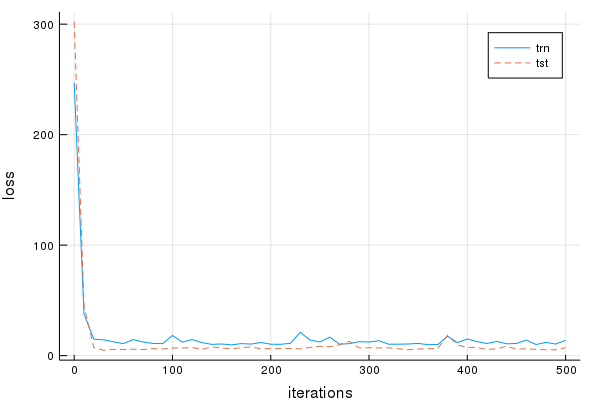

In [342]:
Knet.seed!(42)
model = Linear1(13, 1)
dtrn = HousingDataMinibatch(xtrn, ytrn; shuffle=true)
dtst = HousingDataMinibatch(xtst, ytst)
iters, trnloss, tstloss = mytrain!(model, dtrn, dtst)
plot(iters, [trnloss, tstloss], labels=[:trn, :tst], xlabel="iterations", ylabel="loss")